# Visual Document NER v2

In [ ]:
import json, os
from google.colab import files

with open('spark_ocr_training.json') as f:
  license_keys = json.load(f)

#Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
%pip install spark-nlp==4.0.0
%pip install spark-ocr==$OCR_VERSION+spark32 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade
%pip install spark-nlp-jsl==$JSL_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SECRET --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 531 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.johnsnowlabs.com/4.0.0-49cdb09f66ca01a93f959366f0e4a84d1a09b2df
     |████████████████████████████████| 28.0 MB 1.6 MB/s 
     |████████████████████████████████| 4.3 MB 5.1 MB/s 
     |████████████████████████████████| 198 kB 50.5 MB/s 
     |████████████████████████████████| 29.2 MB 97 kB/s 
     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=33b7dfb0d3a226ae6180fb250060ccc035efc76b96415907f99e16f2ebd3bacd
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
  Attempting uninstall: pil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.johnsnowlabs.com/4.0.0-d7cae1bce9e08f46f643ea4da2c5aa5e0d38be09
     |████████████████████████████████| 190 kB 2.7 MB/s 


In [ ]:
!gdown 1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS

Downloading...
From: https://drive.google.com/uc?id=1e2xnujGxcl0n0mTPNcV_YdlDx0V3NDMS
To: /content/cTDaR_t10096.jpg
100% 385k/385k [00:00<00:00, 108MB/s]


### Initialize Spark session

In [ ]:
from pyspark import SparkConf
from sparkocr import start
import json, os
from google.colab import files

with open('spark_ocr_training.json') as f:
  license_keys = json.load(f)

#Defining license key-value pairs as local variables
#locals().update(license_keys)
for k, v in license_keys.items():
  os.environ[k] = v

spark = start(secret=license_keys['SPARK_OCR_SECRET'])

spark

Spark version: 3.2.1
Spark NLP version: 4.0.0
Spark NLP for Healthcare version: 4.0.0
Spark OCR version: 4.0.0



## Load test images

In [ ]:
import matplotlib.pyplot as plt

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, to_pil_image


print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 4.0.0
Spark NLP internal version: 4.0.0
Spark OCR version: 4.0.0


In [ ]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/usr/local/l...|2022-07-22 12:13:...|421333|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+



## Display images


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


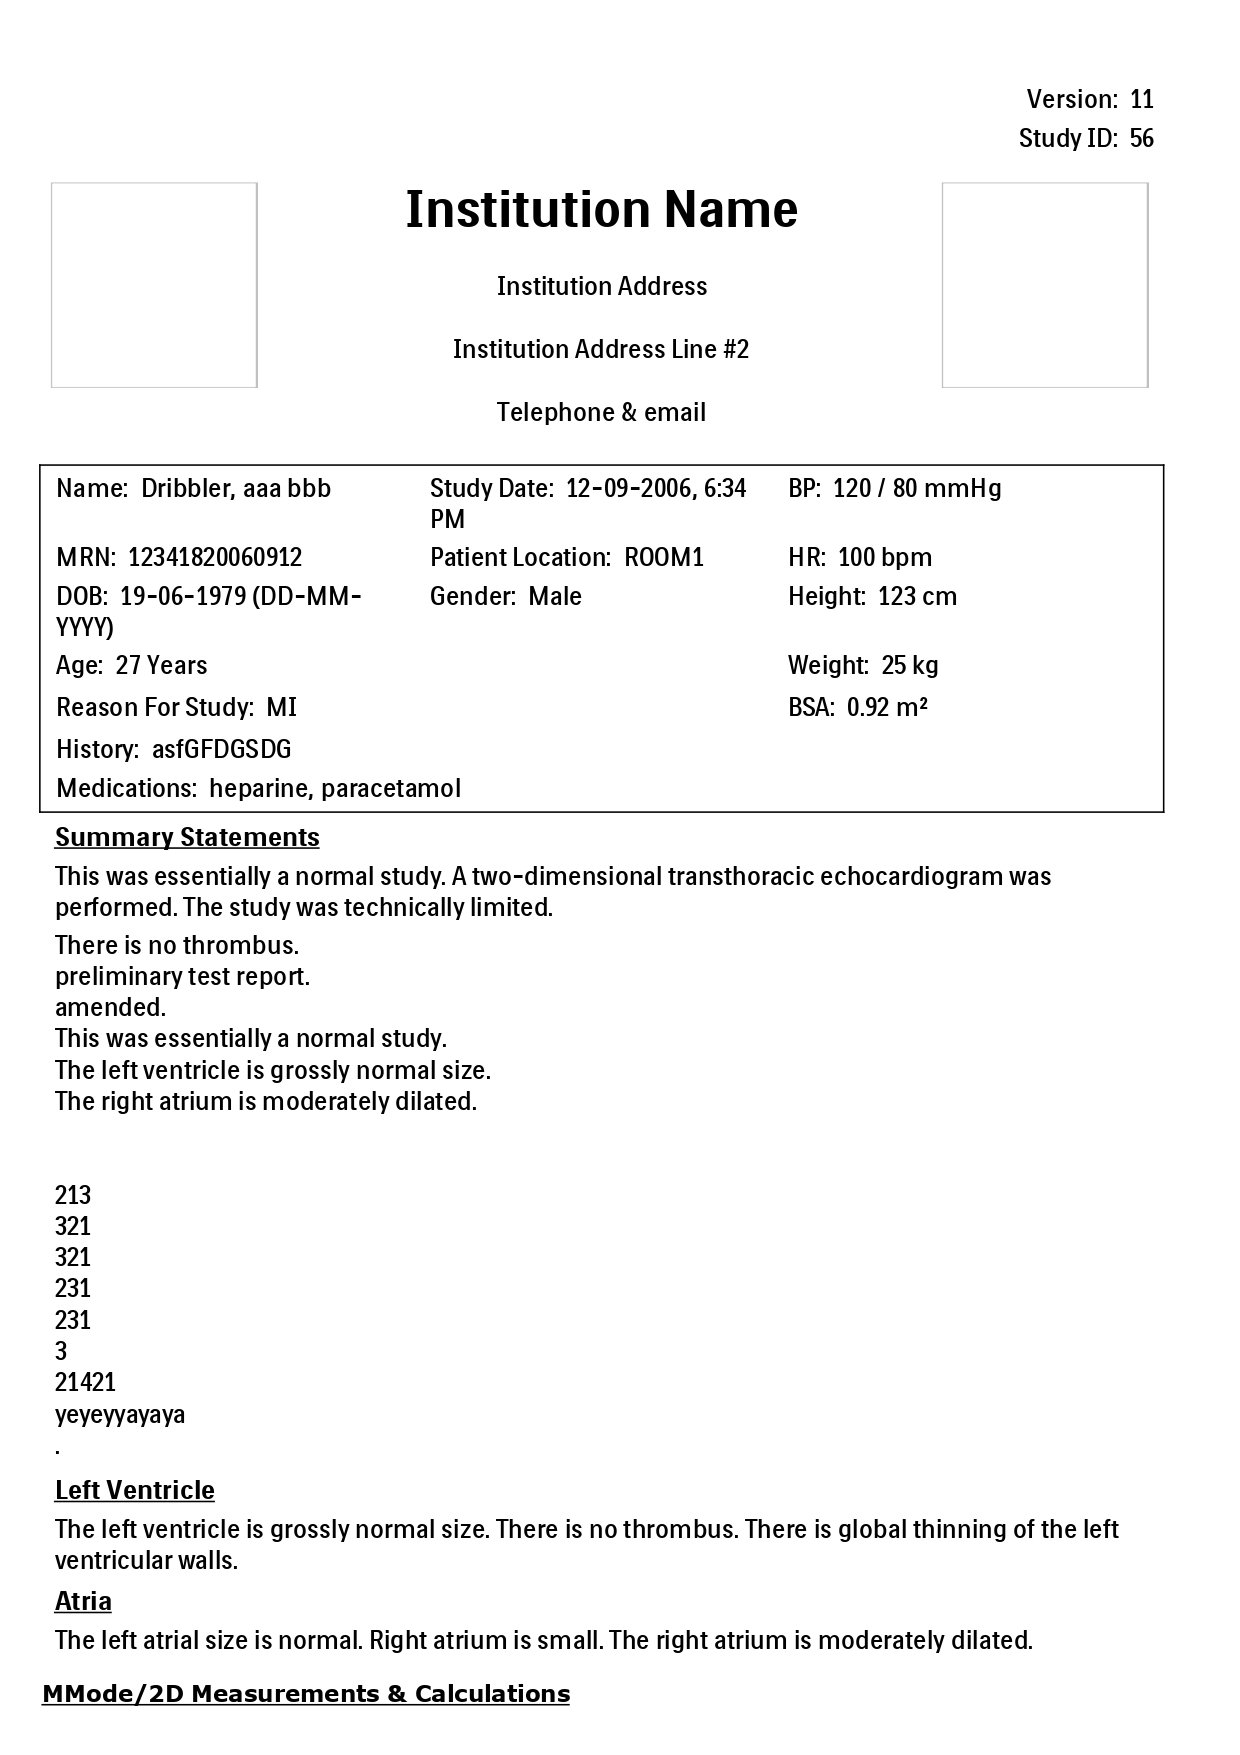

In [ ]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Define pipeline

In [ ]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner = VisualDocumentNerV2()\
    .pretrained("layoutlmv2_key_value_pairs", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

draw = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    draw
])

## Call pipeline

In [ ]:
results = pipeline.transform(bin_df).cache()

## Show results

In [ ]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn("exploded_entities", f.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)
            

AttributeError: ignored

In [ ]:
display_images(results, "image_with_annotations", width=1000)

## Customize labels

In [ ]:
binary_to_image_ = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr_ = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer_ = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner_cust = VisualDocumentNerV2()\
    .pretrained("layoutlmv2_key_value_pairs", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")\
    .setLabels(["other",
                "header",
                "header",
                "key",
                "key",
                "value",
                "value"])\
    .setWhiteList(["header",
                   "key",
                   "value"])

draw_ = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)


# OCR pipeline
pipeline_cust = PipelineModel(stages=[
    binary_to_image_,
    img_to_hocr_,
    tokenizer_,
    doc_ner_cust,
    draw_
])

results_cust = pipeline_cust.transform(bin_df).cache()
display_images(results_cust, "image_with_annotations", width=1000)